# CNNs, ResNets and LR-Scheduling

### Time required to solve this exercise sheet
**As you will train a large number of models on this exercise sheet, model training will require an increased amount of time. So we recommend to start working on this sheet early.**

### Topics

In this exercise sheet, you will:
- work again with CIFAR-10
- implement a 1-layer CNN
- compare MLP and CNN
- vary architecture to improve model performance
- implement a ResNet for CIFAR-10
- learn about learning rate scheduling
- [learn about transfer learning]

*We are looking forward to seeing your solutions! Have fun!*

# IMPORTANT SUBMISSION INSTRUCTIONS

You should work on the exercises in groups of 2-3. It is on you how you collaborate, but please make sure that everyone contributes equally and also that you understand all the solutions.
You will be asked to present your group's solution in the tutorials and you should be well prepared to present any part of it.

- When you've completed the exercise, download the notebook and rename it to ```<surname1>_<surname2>_<surname3>.ipynb```.
- Only submit the Jupyter Notebook (ipynb file). No other file is required. Upload it on `Stud.IP` -> `Deep Learning for Computer Vision` -> `Files` -> `Submission of Homework 3`.
- Make only one submission of the exercise per group.
- The deadline is strict.
- In addition to the submissions, every member of your group should be prepared to present the exercise in the tutorials.

Implementation
- Do not change the cells which are marked as "DO NOT CHANGE", similarly write your solution to the marked cells.

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, StepLR
import torchvision
from torchvision import datasets, transforms, models
import fastprogress
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import time

## 1. Setup

You can use the functions to grab the data, split the sets and create the dataloaders, etc. given to you at exercise sheet 2.

It is good practice to store functions that are constantly needed again in a separate file such that instead of copy-pasting the cells into each exercise notebook, you can use the python file containing the functions and import it in the notebooks.

If you work with Kaggle (which is recommended) you have to mount the drive first and create a path to your python module (or download the file from your drive).

#### **TODO**
Create a file named 'utils.py' and import it here. You can import any package necessary.

In [2]:
# TODO import utils.py
import utils
from utils import *
#get_device
#from utils import get_device

## 2. Load dataset, create dataloader, etc.

#### **TODO**
Call the functions of 'utils.py' to instantiate the train-, test- and validation datasets along with their dataloaders.

In [3]:
# TODO define device
device = get_device()

# Get number of cpus to use for faster parallelized data loading
num_cpus = os.cpu_count()
print(num_cpus, 'CPUs available')

cuda available: True ; cudnn available: True ; num devices: 1

Using device Tesla P100-PCIE-16GB

2 CPUs available


In [4]:
data_dir = 'data'
batch_size = 256


# TODO grab data, generate split, init data loaders
data_dir = pathlib.Path('data/')
trainset, testset, dataset_mean, dataset_std = grab_data(data_dir)
trainset, valset = generate_train_val_data_split(trainset)
trainloader, valloader, testloader = init_data_loaders(trainset, valset, testset, batch_size = batch_size)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data

Files already downloaded and verified

Files already downloaded and verified


#### **TODO** 
Define the loss function. We use the cross entropy loss again.

In [5]:
# TODO define loss function
loss_function = nn.CrossEntropyLoss()


## 3. Simple 1-layer CNN model

### **TODO**
- Define the model.

The first step to training a model is defining its architecture. 
Define a sequential model with following structure:
*   Convolutional layer with 32 filters, kernel size of 5*5 and stride of 1.
*   Max Pooling layer with kernel size of 2*2 and default stride.
*   ReLU Activation Layers.
*   Linear layer with output of 512.
*   ReLU Activation Layers.
*   A linear layer with output of 10.

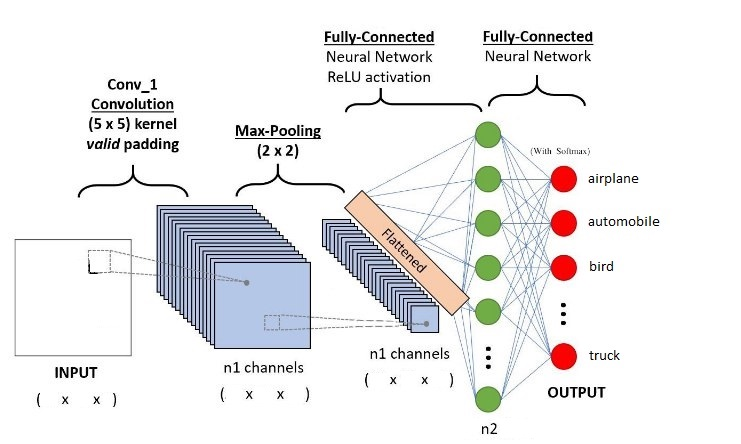

#### **Questions**

- What are the input dimensions?
32x32x3
- What are the dimensions of the feature maps?
28x28x32
- What are the dimensions after pooling?
14x14x32
- What is the value for n2 (in_features)?
6272
- What is the number of parameters for conv_1?
(5x5x3 + 1)x32 = 2432

**Your answers here**

In [6]:
"""
in_channels (int) – Number of channels in the input image

out_channels (int) – Number of channels produced by the convolution

kernel_size (int or tuple) – Size of the convolving kernel

stride (int or tuple, optional) – Stride of the convolution. Default: 1

padding (int, tuple or str, optional) – Padding added to all four sides of the input. Default: 0

padding_mode (str, optional) – 'zeros', 'reflect', 'replicate' or 'circular'. Default: 'zeros'

dilation (int or tuple, optional) – Spacing between kernel elements. Default: 1

groups (int, optional) – Number of blocked connections from input channels to output channels. Default: 1

bias (bool, optional) – If True, adds a learnable bias to the output. Default: True
    
"""

"\nin_channels (int) – Number of channels in the input image\n\nout_channels (int) – Number of channels produced by the convolution\n\nkernel_size (int or tuple) – Size of the convolving kernel\n\nstride (int or tuple, optional) – Stride of the convolution. Default: 1\n\npadding (int, tuple or str, optional) – Padding added to all four sides of the input. Default: 0\n\npadding_mode (str, optional) – 'zeros', 'reflect', 'replicate' or 'circular'. Default: 'zeros'\n\ndilation (int or tuple, optional) – Spacing between kernel elements. Default: 1\n\ngroups (int, optional) – Number of blocked connections from input channels to output channels. Default: 1\n\nbias (bool, optional) – If True, adds a learnable bias to the output. Default: True\n    \n"

In [7]:
class CNN(nn.Module):
    
    def __init__(self, img_width = 32, num_in_channels = 3, num_classes = 10):
        super(CNN, self).__init__()
        
        #dim settings 
        input_dim = num_in_channels*img_width**2
        output_dim = num_classes
        
        
        #architecture
        self.conv_layer = nn.Conv2d(in_channels = 3,out_channels = 32, kernel_size = 5, stride=1)
        self.max_pool = nn.MaxPool2d(kernel_size = 2) #the stride of the window. Default value is kernel_size
        
        self.linear1 = nn.Linear(in_features = 6272,out_features = 500)
        self.linear2 = nn.Linear(in_features = 500,out_features = 10)
        
        #first layer
        self.Conv = nn.Sequential(
        self.conv_layer,
        self.max_pool,
        nn.ReLU())
            
        self.FC = nn.Sequential(
        self.linear1,
        nn.ReLU(),
        self.linear2)

    
    def forward(self, x):
        """Compute model predictions.

        Args:
            x (torch.Tensor, shape (batchsize, num_channels, x, y)): Tensor of
                batch of input images

        Returns:
            torch.Tensor, shape (batchsize, num_classes): Tensor of model
                predictions
        """
        #convolutional layers
        x = self.Conv(x)
        #flattening input
        x = torch.flatten(x, start_dim = 1)
        #fully connected layers
        out = self.FC(x)
        return out

In [8]:
# TODO define model
model = CNN()
model.to(device)
model.train()

print(model)

CNN(

  (conv_layer): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))

  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

  (linear1): Linear(in_features=6272, out_features=500, bias=True)

  (linear2): Linear(in_features=500, out_features=10, bias=True)

  (Conv): Sequential(

    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))

    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

    (2): ReLU()

  )

  (FC): Sequential(

    (0): Linear(in_features=6272, out_features=500, bias=True)

    (1): ReLU()

    (2): Linear(in_features=500, out_features=10, bias=True)

  )

)


#### **TODO**

- Train the model for 10 epochs. Use a learning rate of 0.001.
- Plot the results of accuracy and loss as you did in exercise sheet 2.

Finished training after 136 seconds.


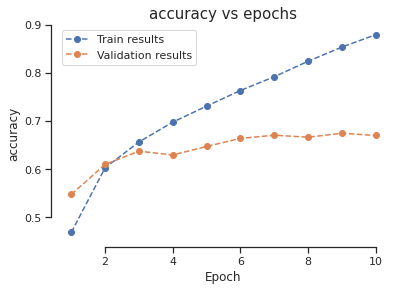

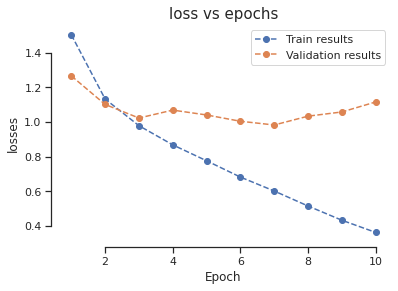

In [9]:
# TODO train and plot

optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10


#(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader, early_stopper=None, verbose=False):
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer,
                loss_function, device, num_epochs, trainloader, valloader , verbose = True)

plot("accuracy vs epochs", "accuracy", train_accs, val_accs)
plot("loss vs epochs", "losses", train_losses, val_losses)

#### **TODO**
Compare results to MLP. What can you observe?
better results in a much shorter time, overfits very quickly.

**Your answers here**

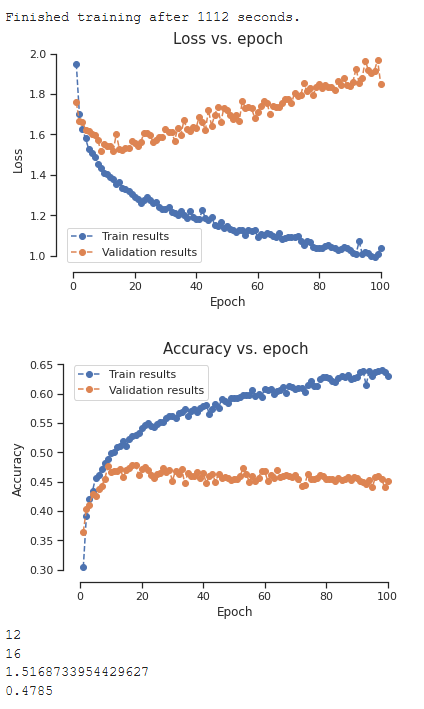

#### **TODO** 
Train longer (ca. 60 epochs), plot again.

Finished training after 824 seconds.


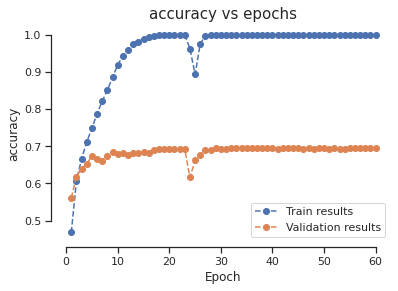

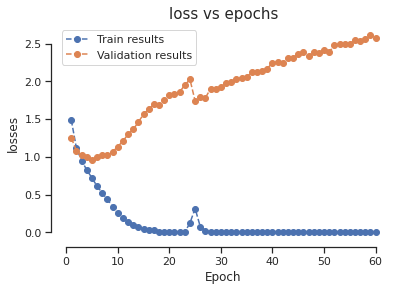

In [15]:
# TODO train and plot

model = CNN()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 60


#(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader, early_stopper=None, verbose=False):
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer,
                loss_function, device, num_epochs, trainloader, valloader , verbose = True)

plot("accuracy vs epochs", "accuracy", train_accs, val_accs)
plot("loss vs epochs", "losses", train_losses, val_losses)

#### **Questions**
- Why is that not an optimal model?
Overfitting occurs after the first 10 epochs, the training accuracy goes up to 1.
- What could be improved?
More layers can be added. Hyperparameters can be tuned and the learning rate can be changed during training. Also early stopping can be employed to stop when the validation accuracy starts to decrease (overfitting occurs).

**Your answers here**

## 4. CNN model with more convolutional layers

#### **TODO**
Define the architecture displayed in the graphic.

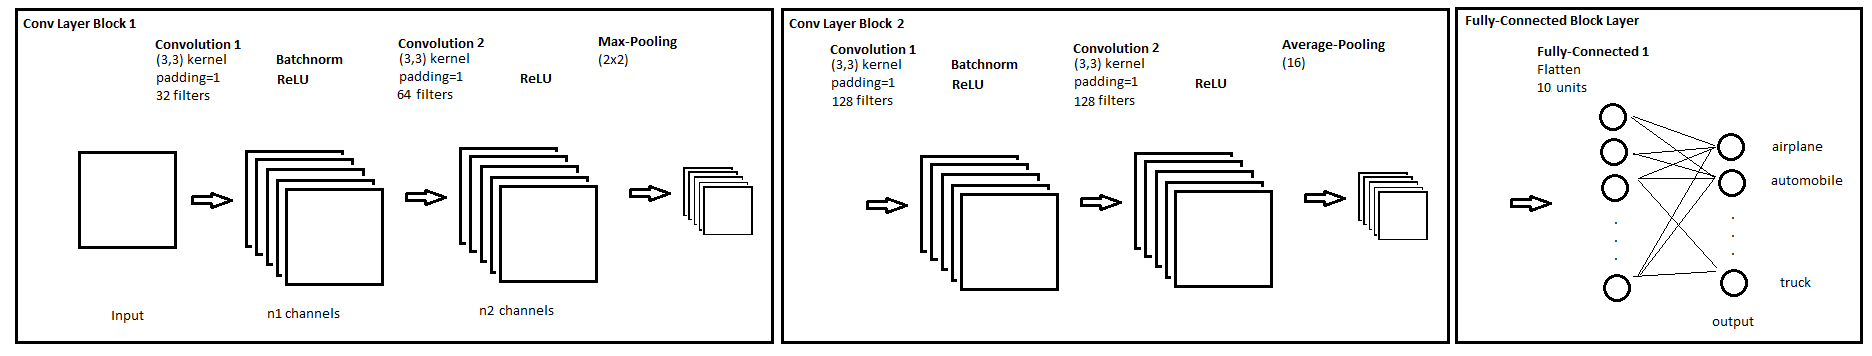

#### **Questions**

- Padding is used in the convolutional layers. What does that mean, which variants exist and how does it influence the dimensions of the feature maps?
- Padding adds a layer of zeros to the boundaries of the matrix. Same padding adds padding so that the kernel will be able to travel to each node.
- What does padding=1 mean in the case of the network displayed above?
- Adding a single layer of zeros to the boundary.
- What are the dimensions of the feature maps after the 1. conv layer?
- 16x16x64
- What are the dimensions of the feature maps after the 2. conv layer?
- 1x1x128
- What ist the receptive field size after the first two convolutions?
- 5x5
- What is the value for the in_features for the fully-connected layer?
- 128
- What is the number of parameters of *Conv Layer block 1*?
- (3x3x3+1)x32 + (3x3x32+1)x64 = 19392

**Your answers here**

In [11]:
class CNN2(nn.Module):

    def __init__(self, img_width = 32, num_in_channels = 3, num_classes = 10):
        super(CNN2, self).__init__()
        
        #dim settings 
        input_dim = num_in_channels*img_width**2
        output_dim = num_classes
        
        
        #architecture
        
        self.Conv_layer1 = nn.Sequential(
        nn.Conv2d(in_channels = 3,out_channels = 32, kernel_size = 3, stride=1, padding = 1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(in_channels = 32,out_channels = 64, kernel_size = 3, stride=1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2))
        
        self.Conv_layer2 = nn.Sequential(
        nn.Conv2d(in_channels = 64,out_channels = 128, kernel_size = 3, stride=1, padding = 1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(in_channels = 128,out_channels = 128, kernel_size = 3, stride=1, padding = 1),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size = 16))
        
        self.FC = nn.Linear(128,10)

    
    def forward(self, x):
        """Compute model predictions.

        Args:
            x (torch.Tensor, shape (batchsize, num_channels, x, y)): Tensor of
                batch of input images

        Returns:
            torch.Tensor, shape (batchsize, num_classes): Tensor of model
                predictions
        """
        #convolutional layers
        x = self.Conv_layer1(x)
        x = self.Conv_layer2(x)
        #flattening input
        x = torch.flatten(x, start_dim = 1)
        #fully connected layer
        out = self.FC(x)
        return out

In [12]:
#TODO define model 2
model2 = CNN2()
model2.to(device)
model2.train()

print(model2)

CNN2(

  (Conv_layer1): Sequential(

    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    (2): ReLU()

    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    (4): ReLU()

    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

  )

  (Conv_layer2): Sequential(

    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    (2): ReLU()

    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    (4): ReLU()

    (5): AvgPool2d(kernel_size=16, stride=16, padding=0)

  )

  (FC): Linear(in_features=128, out_features=10, bias=True)

)


#### **TODO** 

- train the new net (30 epochs, lr=0.1), plot the results, and compare the results to the 1-layer CNN
- explain why you observe these results
- The model is underfitting, since it takes too long to train the vast amount of parameters used in this deep er neural network. Due to the many layers, the gradients of each parameter turn out to become very small, which greatly hampers the learning of the network.

Finished training after 444 seconds.


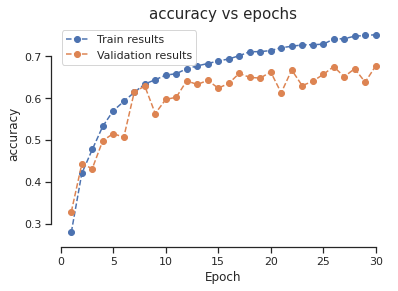

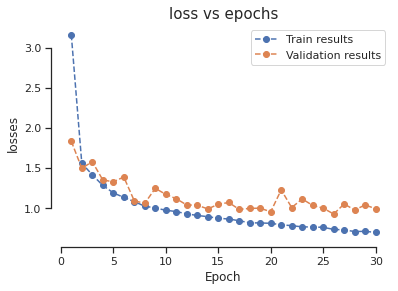

In [13]:
# TODO train and plot
optimizer = optim.Adam(model2.parameters(), lr=1e-1)
num_epochs = 30


#(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader, early_stopper=None, verbose=False):
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model2, optimizer,
                loss_function, device, num_epochs, trainloader, valloader , verbose = True)

plot("accuracy vs epochs", "accuracy", train_accs, val_accs)
plot("loss vs epochs", "losses", train_losses, val_losses)

## 5. ResNet architecture

"*Deeper neural networks are more difficult to train.  We present a residual learning framework to ease the training of networks that are substantially deeper than those used previously.*" [ https://arxiv.org/pdf/1512.03385.pdf]

That was the intention of He et al. to develop residual networks.

A ResNet is built of blocks which are called the *Residual Blocks*. 
A residual block uses *skip connections* - shortCuts — to jump over some layers to skip some activations.
The Resnet skips connections via addition.

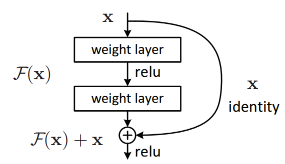

#### **Questions**
- Which problems do using skip connections solve?
- The vanishing gradient problem
- Why is a residual network called residual?
- The feed forward structure forwards the previous outputs to later layers.
- When is the advantage of ResNets over 'normal' CNNs most visible?
- When the neural network is deeper.

**Your answers here**

#### **TODO**
- write a class **ResidualBlock(nn.Module)** where you define the blocks used in the ResNet
- write a class **ResNet(nn.Module)** where you define the model
- train the model
- plot results

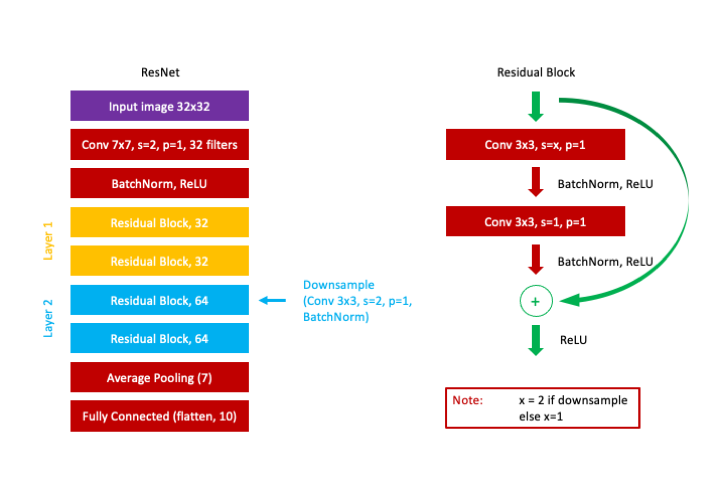

**Hints**

- The downsampling in this ResNet happens between layer 1 and layer 2. In this step, the channel size is increased (32 -> 64) and the image resolution is downsampled by strided convolution (stride=2 in the Conv2d layers).
- For the adding part, the dimensions obviously have to be the same. This is accomplished by using stride=2 in the first Conv2d layer of the block while the second layer does not change the dimensions.
- The average-pooling layer has kernel size 7.
- For you to ensure everything works fine, here are the shapes in the form [(batchsize), x, y, channel] where I discard batchsize, because it does not change.
32x32x3 -> conv 7x7 -> 14x14x32 -> layer 1 -> 14x14x32 -> layer2 -> 7x7x64 -> avpool(7) -> 1x1x64 -> linear(64, 10)

In [14]:
# TODO write a class ResidualBlock(nn.Module) where you define the blocks used in the ResNet

class ResidualBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(ResidualBlock, self).__init__()
        
        #determining stride
        
        if(in_channel != out_channel):
            stride = 2
        else:
            stride = 1
            
        self.stride = stride
        
        #architecture
        
        self.Conv_layer = nn.Sequential(
        nn.Conv2d(in_channels = in_channel,out_channels = out_channel, kernel_size = 3, stride=stride, padding = 1),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(),
        nn.Conv2d(in_channels = out_channel,out_channels = out_channel, kernel_size = 3, stride=1, padding = 1),
        nn.BatchNorm2d(out_channel))
        
        self.shortcut = nn.Sequential(nn.Conv2d(in_channels = in_channel,out_channels = out_channel, kernel_size = 1, stride=stride),
        nn.BatchNorm2d(out_channel))
        
        self.ReLU = nn.ReLU()
        
    def forward(self, x):
        
        residual = x
        #checking dimensions
        if(self.stride == 2): residual = self.shortcut(residual)
            
        #convolutional layer
        x = self.Conv_layer(x)
        
        #addition and ReLU
        out = self.ReLU(residual+x)
        
        return out
        
"""
    def forward(self, x):
        
        residual = x
        #checking dimensions
        if(self.stride == 2): residual = self.shortcut(residual)
            
        #convolutional layer
        x = self.Conv_layer(x)
        
        #addition and ReLU
        out = nn.ReLU(residual+x)
        
        return out
"""

'\n    def forward(self, x):\n        \n        residual = x\n        #checking dimensions\n        if(self.stride == 2): residual = self.shortcut(residual)\n            \n        #convolutional layer\n        x = self.Conv_layer(x)\n        \n        #addition and ReLU\n        out = nn.ReLU(residual+x)\n        \n        return out\n'

In [15]:
# TODO write a class ResNet(nn.Module) where you define the model

class ResNet(nn.Module):
    def __init__(self, img_width = 32, num_in_channels = 3, num_classes = 10):
        super(ResNet, self).__init__()
        
        #dim settings 
        input_dim = num_in_channels*img_width**2
        output_dim = num_classes
        
        
        #architecture
        
        self.Conv_layer1 = nn.Sequential(
        nn.Conv2d(in_channels = 3,out_channels = 32, kernel_size = 7, stride=2, padding = 1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        ResidualBlock(32,32),
        ResidualBlock(32,32),
        ResidualBlock(32,64),
        ResidualBlock(64,64),
        nn.AvgPool2d(kernel_size = 7))
        
        self.FC = nn.Linear(64,10)
    
    def forward(self, x):

        #convolutional layers
        x = self.Conv_layer1(x)
        #flattening input
        x = torch.flatten(x, start_dim = 1)
        #fully connected layer
        out = self.FC(x)
        return out

In [16]:
# TODO write a class ResNet(nn.Module) where you define the model

class ResNetFull(nn.Module):
    def __init__(self, img_width = 32, num_in_channels = 3, num_classes = 10):
        super(ResNetFull, self).__init__()
        
        #dim settings 
        input_dim = num_in_channels*img_width**2
        output_dim = num_classes
        
        
        #architecture
        
        self.Before = nn.Sequential(
        nn.Conv2d(in_channels = 3,out_channels = 32, kernel_size = 7, stride=2, padding = 1),
        nn.BatchNorm2d(32),
        nn.ReLU())
        
        self.Layer32 = nn.Sequential(
        nn.Conv2d(32,32, kernel_size = 3, stride=1, padding = 1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(32,32, kernel_size = 3, stride=1, padding = 1),
        nn.BatchNorm2d(32))
        
        self.LayerTrans = nn.Sequential(
        nn.Conv2d(32,64, kernel_size = 3, stride=2, padding = 1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64,64, kernel_size = 3, stride=1, padding = 1),
        nn.BatchNorm2d(64))
        
        self.Layer64 = nn.Sequential(
        nn.Conv2d(64,64, kernel_size = 3, stride=1, padding = 1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64,64, kernel_size = 3, stride=1, padding = 1),
        nn.BatchNorm2d(64))
        
                    
        self.ReLU = nn.ReLU()
        self.av_pool = nn.AvgPool2d(kernel_size = 7)
        self.FC = nn.Linear(64,10)
        
        
        self.shortcut = nn.Sequential(
        nn.Conv2d(32,64, kernel_size = 1, stride=2),
        nn.BatchNorm2d(64))
    
    
    def forward(self, x):

        #convolutional layers
        x = self.Before(x)
        
        residual = x
        x = self.Layer32(x)   
        x = self.ReLU(x + residual)
        
        residual = x
        x = self.Layer32(x)   
        x = self.ReLU(x + residual)
        
        residual = x
        x = self.LayerTrans(x)
        residual = self.shortcut(residual)
        x = self.ReLU(x + residual)
        
        residual = x
        x = self.Layer64(x)
        x = self.ReLU(x + residual)
        
        x = self.av_pool(x)
        
        #flattening input
        x = torch.flatten(x, start_dim = 1)     
        
        #fully connected layer
        out = self.FC(x)
        
        return out

In [17]:
# TODO train ResNet, using the architecture laid out in the comments and figures above


Residual_Net = ResNet()
Residual_Net.to(device)
Residual_Net.train()

optimizer = optim.Adam(Residual_Net.parameters(), lr=1e-4)
num_epochs = 10


#(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader, early_stopper=None, verbose=False):
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(Residual_Net, optimizer,
                loss_function, device, num_epochs, trainloader, valloader , verbose = True)


Finished training after 141 seconds.


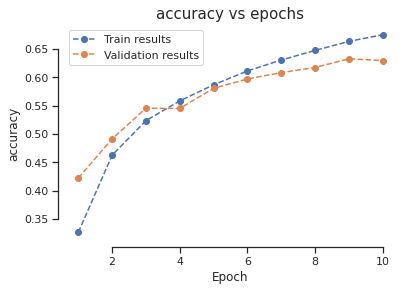

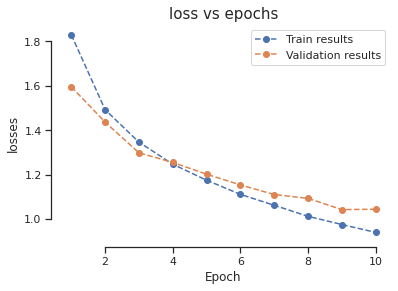

In [18]:
# TODO plot loss and accuracy for training and validation set
plot("accuracy vs epochs", "accuracy", train_accs, val_accs)
plot("loss vs epochs", "losses", train_losses, val_losses)

#### **Questions**
- Does the performance increase compared to the CNNs you trained before? Why/Why not?
- A bit better than CNN version of the Network.
- Compare the runtime of CNN and ResNet.
- Run times were similar.

**Your answers here**

In [19]:
# TODO write a class ResNet(nn.Module) where you define the model

class CNNRes(nn.Module):
    def __init__(self, img_width = 32, num_in_channels = 3, num_classes = 10):
        super(CNNRes, self).__init__()
        
        #dim settings 
        input_dim = num_in_channels*img_width**2
        output_dim = num_classes
        
        
        #architecture
        
        self.Before = nn.Sequential(
        nn.Conv2d(in_channels = 3,out_channels = 32, kernel_size = 7, stride=2, padding = 1),
        nn.BatchNorm2d(32),
        nn.ReLU())
        
        self.Layer32 = nn.Sequential(
        nn.Conv2d(32,32, kernel_size = 3, stride=1, padding = 1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(32,32, kernel_size = 3, stride=1, padding = 1),
        nn.BatchNorm2d(32))
        
        self.LayerTrans = nn.Sequential(
        nn.Conv2d(32,64, kernel_size = 3, stride=2, padding = 1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64,64, kernel_size = 3, stride=1, padding = 1),
        nn.BatchNorm2d(64))
        
        self.Layer64 = nn.Sequential(
        nn.Conv2d(64,64, kernel_size = 3, stride=1, padding = 1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64,64, kernel_size = 3, stride=1, padding = 1),
        nn.BatchNorm2d(64))
             
        self.ReLU = nn.ReLU()
        self.av_pool = nn.AvgPool2d(kernel_size = 7)
        self.FC = nn.Linear(64,10)
    
    
    def forward(self, x):

        #convolutional layers
        x = self.Before(x)
        
        x = self.Layer32(x)   
        x = self.ReLU(x)
        
        x = self.Layer32(x)   
        x = self.ReLU(x)
        
        x = self.LayerTrans(x)
        x = self.ReLU(x)
        
        x = self.Layer64(x)
        x = self.ReLU(x)
        
        x = self.av_pool(x)
        
        #flattening input
        x = torch.flatten(x, start_dim = 1)     
        
        #fully connected layer
        out = self.FC(x)
        
        return out

In [20]:
# TODO train ResNet, using the architecture laid out in the comments and figures above

Residual_Net = CNNRes()
Residual_Net.to(device)
Residual_Net.train()

optimizer = optim.Adam(Residual_Net.parameters(), lr=1e-4)
num_epochs = 10

#(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader, early_stopper=None, verbose=False):
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(Residual_Net, optimizer,
                loss_function, device, num_epochs, trainloader, valloader , verbose = True)


Finished training after 135 seconds.


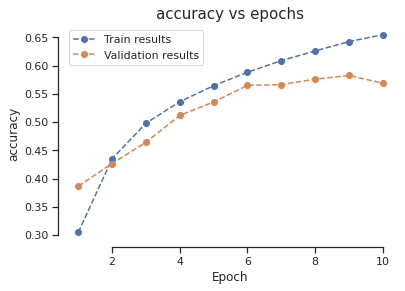

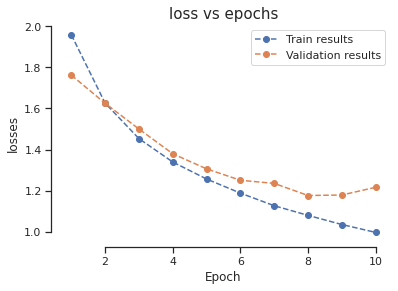

In [21]:
# TODO plot loss and accuracy for training and validation set
plot("accuracy vs epochs", "accuracy", train_accs, val_accs)
plot("loss vs epochs", "losses", train_losses, val_losses)

## 6. Explore Learning Rate Scheduling

Learning rate scheduling is a mechanism to adjust the learning rate.

*torch.optim.lr_scheduler* provides several methods based on the number of epochs. Learning rate scheduling should be applied after optimizer’s update.

#### **TODO**
- change run_training and extend to use scheduler for learning rate
- use StepLR (https://pytorch.org/docs/stable/optim.html), use the ResNet, train for 10 epochs. Start with a learning rate of 0.1.


#### **Questions**

- Try step size 1, gamma 0.1
    - How does it change the learning rate?
    multiplies the lr by 0.1 at each step
    - what do you observe regarding performance?
    the accuracy is worse it underfits due to the lowering learning rate.
- Try step size 1, gamma 0.9, what do you observe?
    - How does it change the learning rate?
    multiplies the lr by 0.9 at each step
    - what do you observe regarding performance?
    much better performance than gamma = 0.1 but still a bit worse than the original
- What can you conclude of this experiment regarding the synergy of step size and gamma to get a good schedule?
- The optimal learning rate is a function of epochs so at the right step size, if a change of gamma were to occur we can get a better accuracy. The learning rate needs to decrease at certain steps during the training to reach closer to a minimum.

**Your answers here**

In [22]:
# TODO change run_training (you can copy the code from utils.py here and create a new method here 
# or just change/create a new method it in the python file)

def run_training(model, optimizer, loss_function, device, num_epochs, 
                train_dataloader, val_dataloader, scheduler, early_stopper=None, verbose=False):
    """Run model training.

    Args:
        model (nn.Module): Torch model to train
        optimizer: Torch optimizer object
        loss_fn: Torch loss function for training
        device (torch.device): Torch device to use for training
        num_epochs (int): Max. number of epochs to train
        train_dataloader (DataLoader): Torch DataLoader object to load the
            training data
        val_dataloader (DataLoader): Torch DataLoader object to load the
            validation data
        early_stopper (EarlyStopper, optional): If passed, model will be trained
            with early stopping. Defaults to None.
        verbose (bool, optional): Print information about model training. 
            Defaults to False.

    Returns:
        list, list, list, list, torch.Tensor shape (10,10): Return list of train
            losses, validation losses, train accuracies, validation accuracies
            per epoch and the confusion matrix evaluated in the last epoch.
    """
    start_time = time.time()
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses, train_accs, val_accs = [],[],[],[]

    for epoch in master_bar:
        # Train the model
        epoch_train_loss, epoch_train_acc = train(train_dataloader, optimizer, model, 
                                                  loss_function, device, master_bar)
        #scheduler
        
        scheduler.step()
        #my_lr = scheduler.get_lr()
        #print(my_lr)
        
        # Validate the model
        epoch_val_loss, epoch_val_acc, confusion_matrix = validate(val_dataloader, 
                                                                   model, loss_function, 
                                                                   device, master_bar)

        # Save loss and acc for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)
        
        if verbose:
            master_bar.write(f'Train loss: {epoch_train_loss:.2f}, val loss: {epoch_val_loss:.2f}, train acc: {epoch_train_acc:.3f}, val acc {epoch_val_acc:.3f}')
            
    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    return train_losses, val_losses, train_accs, val_accs, confusion_matrix



Adjusting learning rate of group 0 to 1.0000e-01.


Adjusting learning rate of group 0 to 1.0000e-02.

Adjusting learning rate of group 0 to 1.0000e-03.

Adjusting learning rate of group 0 to 1.0000e-04.

Adjusting learning rate of group 0 to 1.0000e-05.

Adjusting learning rate of group 0 to 1.0000e-06.

Adjusting learning rate of group 0 to 1.0000e-07.

Adjusting learning rate of group 0 to 1.0000e-08.

Adjusting learning rate of group 0 to 1.0000e-09.

Adjusting learning rate of group 0 to 1.0000e-10.

Adjusting learning rate of group 0 to 1.0000e-11.

Finished training after 138 seconds.


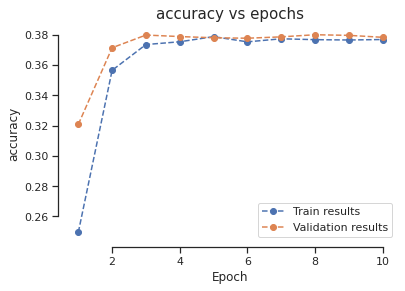

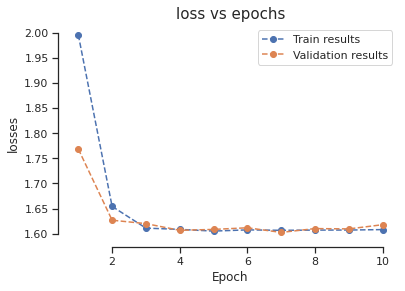

In [23]:
# TODO train and plot with step size 1, gamma 0.1

Residual_Net = ResNet()
Residual_Net.to(device)
Residual_Net.train()

optimizer = optim.Adam(Residual_Net.parameters(), lr=0.1)
scheduler = StepLR(optimizer, step_size = 1, gamma=0.1, verbose=True)
num_epochs = 10


#(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader, early_stopper=None, verbose=False):
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(Residual_Net, optimizer,
                loss_function, device, num_epochs, trainloader, valloader , scheduler, verbose = True)

plot("accuracy vs epochs", "accuracy", train_accs, val_accs)
plot("loss vs epochs", "losses", train_losses, val_losses)

Adjusting learning rate of group 0 to 1.0000e-01.


Adjusting learning rate of group 0 to 9.0000e-02.

Adjusting learning rate of group 0 to 8.1000e-02.

Adjusting learning rate of group 0 to 7.2900e-02.

Adjusting learning rate of group 0 to 6.5610e-02.

Adjusting learning rate of group 0 to 5.9049e-02.

Adjusting learning rate of group 0 to 5.3144e-02.

Adjusting learning rate of group 0 to 4.7830e-02.

Adjusting learning rate of group 0 to 4.3047e-02.

Adjusting learning rate of group 0 to 3.8742e-02.

Adjusting learning rate of group 0 to 3.4868e-02.

Finished training after 139 seconds.


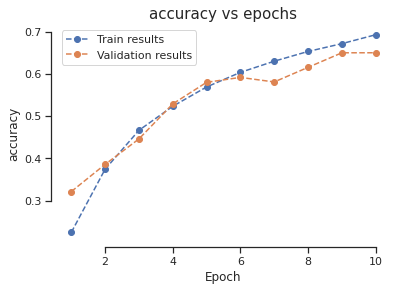

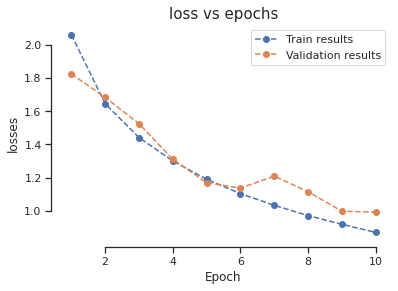

In [24]:
# TODO train and plot with step size 1, gamma 0.9

Residual_Net = ResNet()
Residual_Net.to(device)
Residual_Net.train()

optimizer = optim.Adam(Residual_Net.parameters(), lr=0.1)
scheduler = StepLR(optimizer, step_size = 1, gamma=0.9, verbose=True)
num_epochs = 10


#(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader, early_stopper=None, verbose=False):
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(Residual_Net, optimizer,
                loss_function, device, num_epochs, trainloader, valloader , scheduler, verbose = True)

plot("accuracy vs epochs", "accuracy", train_accs, val_accs)
plot("loss vs epochs", "losses", train_losses, val_losses)

#### **TODO** 

Use step size 15, gamma 0.1. Train for 30 epochs.

#### **Questions**
- Does it improve performance?
yes the performance is much better
- What can you observe in the plots?
when the learning rate changes there is a jump in accuracy which was stabilized at a lower level.

**Your answers here**

Adjusting learning rate of group 0 to 1.0000e-01.


Adjusting learning rate of group 0 to 1.0000e-01.

Adjusting learning rate of group 0 to 1.0000e-01.

Adjusting learning rate of group 0 to 1.0000e-01.

Adjusting learning rate of group 0 to 1.0000e-01.

Adjusting learning rate of group 0 to 1.0000e-01.

Adjusting learning rate of group 0 to 1.0000e-01.

Adjusting learning rate of group 0 to 1.0000e-01.

Adjusting learning rate of group 0 to 1.0000e-01.

Adjusting learning rate of group 0 to 1.0000e-01.

Adjusting learning rate of group 0 to 1.0000e-01.

Adjusting learning rate of group 0 to 1.0000e-01.

Adjusting learning rate of group 0 to 1.0000e-01.

Adjusting learning rate of group 0 to 1.0000e-01.

Adjusting learning rate of group 0 to 1.0000e-01.

Adjusting learning rate of group 0 to 1.0000e-02.

Adjusting learning rate of group 0 to 1.0000e-02.

Adjusting learning rate of group 0 to 1.0000e-02.

Adjusting learning rate of group 0 to 1.0000e-02.

Adjusting learning rate of group 0 to 1.0000e-02.

Adjusting learning rate of grou

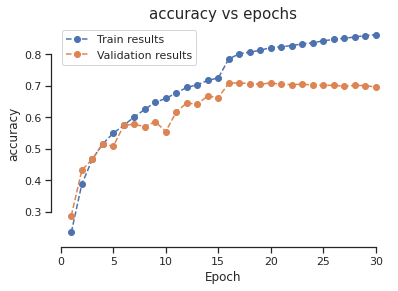

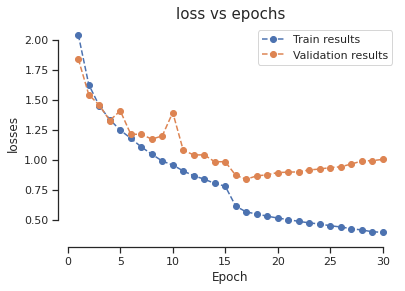

In [25]:
# TODO train and plot with step size 15, gamma 0.1, 30 epochs.

Residual_Net = ResNet()
Residual_Net.to(device)
Residual_Net.train()

optimizer = optim.Adam(Residual_Net.parameters(), lr=0.1)
scheduler = StepLR(optimizer, step_size = 15, gamma=0.1, verbose=True)
num_epochs = 30


#(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader, early_stopper=None, verbose=False):
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(Residual_Net, optimizer,
                loss_function, device, num_epochs, trainloader, valloader , scheduler, verbose = True)

plot("accuracy vs epochs", "accuracy", train_accs, val_accs)
plot("loss vs epochs", "losses", train_losses, val_losses)